# Spam Email Classifier

## Feature Engineering, Classification, and Cross Validation

## Introduction
In this project, I build a Spam Email Classifier, and then evaluate the model's accuracy. I'll use `sklearn` libraries to process data and fit the models, Validate the performance and minimize overfitting, and generate and analyze the ROC curve.

#### Content Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

In [138]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [139]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## Loading and Cleaning Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load in the data into a `DataFrame`.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` DataFrame contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [140]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [141]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [142]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

We split the training data into separate training and validation datasets to assess the performance of the classifier after we finishing using the training data to build our model. 

In [143]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

## Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$. The `words_in_texts` creates numeric features derived from the email and uses those features for logistic regression. 

In [144]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Let's see how this function works on some random "dummy" words.

In [145]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In [146]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [147]:
from sklearn.linear_model import LogisticRegression

train_model = LogisticRegression(solver = 'lbfgs')
train_model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False Positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False Negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False positive rate**: Measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on both the train and test set (see Q4 for the partial credit breakdown). To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

Brainstorming ways to improve my model: 

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.
    1. I  imported `GridSearchCV`. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/1.1/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)) class to perform cross-validation. You do not need to code your own CV from scratch, though you are welcome to do so.


---

**Note:** *It may be beneficial **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, I may overfit to my validation set if I try to optimize my validation accuracy too much. Alternatively, I can perform cross-validation on the entire training set.


---

,id,subject,email,spam,special_char_count,special_char_proportion
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,2,0.001219
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,0,0.000000
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,3,0.002144
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,2,0.000451
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,44,0.001339
...,...,...,...,...,...,...
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0,0,0.000000
7509,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale...",1,36,0.005103
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0,3,0.001732
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0,0,0.000000


LogisticRegression()

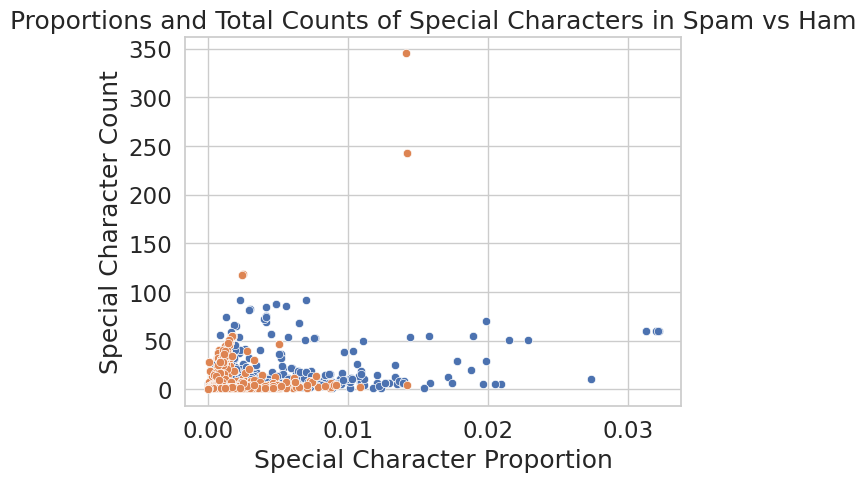

In [148]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

# finding the number of special characters 
def special_character_classifier(train_df):
    special_char_count = train_df["email"].str.count(r"!")
    special_char_proportion = special_char_count / train_df["email"].str.len()
    train_df["special_char_count"] = special_char_count
    train_df["special_char_proportion"] = special_char_proportion
    
# email length classifier
def email_len(train_df, email_len):
    long_email = (train_df["email"].str.len() > email_len).astype(int)
    return long_email

special_character_classifier(train)
train_outliers = train[train["special_char_proportion"] < 0.04]
train_outliers = train_outliers[train_outliers["special_char_proportion"] < 100]

spam_special_char = train_outliers[train_outliers["spam"] == 1]
ham_special_char = train_outliers[train_outliers["spam"] == 0]

# visualizing this information to see if it is even a helpful metric
sns.scatterplot(data=spam_special_char, x="special_char_proportion", y="special_char_count")
sns.scatterplot(data=ham_special_char, x="special_char_proportion", y="special_char_count")
plt.xlabel("Special Character Proportion")
plt.ylabel("Special Character Count")
plt.title("Proportions and Total Counts of Special Characters in Spam vs Ham")
display(train)

# classification words 
my_words = ['bank', 'html', 'love', '<', '>', 'url', 'free', 'today', 
            'exclusive', 'deal', 'huge', 'click', 'nigerian', 'prince', 
            'respond', 'rich', 'sex', 'body', 'drugs', 'guarantee', 
            'love', 'dog', 'near', 'join', 'viagra', 'private', 
            'congratulations']

train_test = words_in_texts(my_words, train["email"])
X_train = pd.DataFrame(train_test, columns=my_words)
X_train_final = X_train
Y_train = train["spam"].array

train_model = LogisticRegression(solver='lbfgs')
train_model.fit(X_train_final, Y_train)

<!-- BEGIN QUESTION -->

<br><br>

---

## Improving the Model

1. I thought about my experience with spam emails and came up with a list of words that frequently appear. I cross-referenced this list with some of the words that my classmates to determine if there might be colinearity or not.
2. Heatmaps of the correlations helps us better visualize potential colinearity or interdependence between variables, thus, helps me identify which words are better/worse to improve my model's performance.
3. The length of emails is a relevant statistic/factor, because many spam emails are very long since they are trying to persuade you to do/buy/think/react to something. 

Edit: I also included HTML tags/code to identify which emails are spam, since most of them use HTML-like formatting. Finding better features for my model took a lot of time and discussion with classmates, TA's in office hours, and advice/approaches from former students. 
Initially, I tried adding lots of words like "bank", "drug", "prescription", "rich", etc. but realized that it would create lots of colinearity. Repetively creating a heatmap for these words and evaluating which ones are the most useful for my model helped me cast a wide net and narrow down the list. 
It was surprising to learn that some "random" words like "love" and "dog" are useful because they further separate spam and ham emails, considering they are probably usually very uncommon in spam emails. 

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis & Visualizations

Here, I visualize some features of my model, including:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

,id,subject,email,spam,special_char_count,special_char_proportion,email len
3756,1309,Subject: Mortgage Rates Are Down. teoqknmp\n,when america's top companies compete for your ...,1,1,0.001189,841
1687,5337,Subject: Last time you spent $25 did u make $1...,hello\n \n you may have seen this business bef...,1,31,0.001866,16617
1680,8142,Subject: Herbal Viagra 30 day trial.... ...,<html>\n <head>\n <title></title>\n </head>\n ...,1,3,0.002625,1143
6251,3762,Subject: ADV: Search Engine Placement\n,to remove see below.\n \n i work with a compan...,1,1,0.001957,511
1683,8069,Subject: [ILUG] BUSINESS\n,central bank of nigeria\n foreign remittance d...,1,0,0.000000,2687
...,...,...,...,...,...,...,...
2877,2907,Subject: Re: Al'Qaeda's fantasy ideology: Poli...,">see jared diamond's excellent ""guns, germs, a...",0,0,0.000000,982
2876,2068,"Subject: Great DVD interaction tool, probably ...",url: http://boingboing.net/#85481626\n date: n...,0,0,0.000000,793
2875,7644,Subject: Not just like a virgin...a virgin...b...,\n rare virgin shark births reported in detroi...,0,0,0.000000,479
2874,7694,Subject: [Spambayes] Re: [Python-Dev] Getting ...,"on 06 september 2002, anthony baxter said:\n >...",0,1,0.001650,606


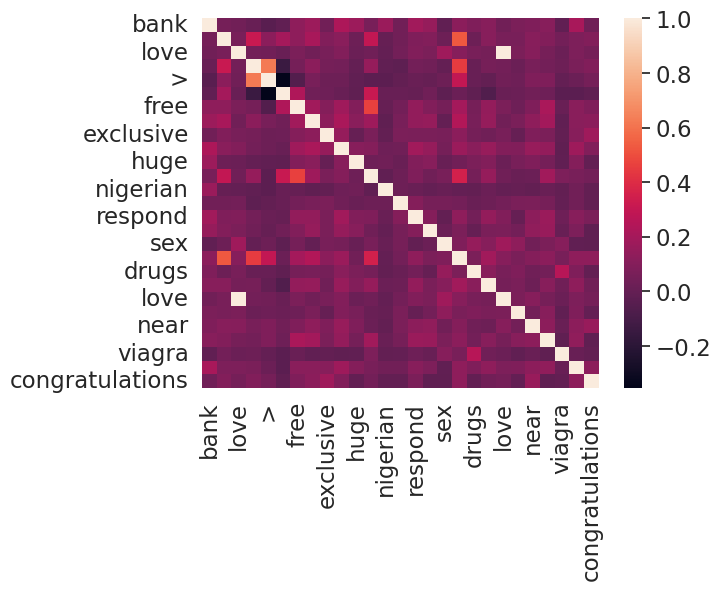

In [149]:
# visualizing potential colinearity amongst words chosen to build classifier
test_df = pd.DataFrame(train_test, columns=my_words)
sns.heatmap(test_df.corr())

# email length lineplot
train_email_len = train.sort_values("spam", ascending=False)
train_email_len["email len"] = train_email_len["email"].str.len()
display(train_email_len)

train_email_len = train_email_len[train_email_len["email len"] < 2000]
spam_len_df = train_email_len[['spam', 'email len']]

spam_len_counts = spam_len_df[spam_len_df['spam']==1][['email len']].value_counts()
ham_len_counts = spam_len_df[spam_len_df['spam']==0][['email len']].value_counts()

My data visualization is a heatmap for the words that I choose to use to classify an email as spam vs ham. This heatmap helps me identify which words might establish colinearity or redunancy in my classifier, thus, identify better words or phrases to build a more accurate and compelling classifier. 
Edit: As I continued building my model and tried to determine which words might have colinearity and how to add words to improve performance, I realized that it would be a very good idea to add HTML tags/code for the classifier. I also realized that it might helpful to add more "positive" words like "love" and "dog" to further separate spam from ham. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

## ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff threshold*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

***The Receiver Operating Characteristic (ROC) curve shows this trade off for each possible cutoff probability. In the cell below, I plot a ROC curve for my final classifier (the one I use to make predictions for on the training data).***


Text(0.5, 1.0, 'My Training Model ROC Curve')

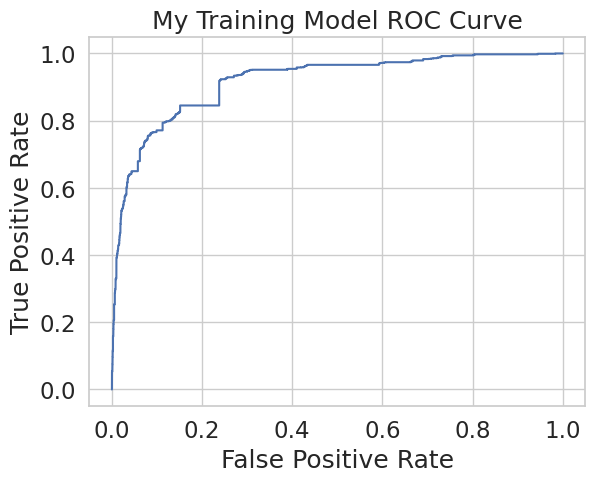

In [158]:
from sklearn.metrics import roc_curve

our_probs = train_model.predict_proba(X_train)[:, 1]
false_pos_rate, true_pos_rate, threshold = roc_curve(Y_train, our_probs, pos_label=1)

plt.step(false_pos_rate, true_pos_rate, color='b', alpha=1, where='post')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('My Training Model ROC Curve')

In [151]:
train_predictions = train_model.predict(words_in_texts(my_words, train["email"]))
train_predictions

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0, 0, 0, ..., 1, 0, 0])

<br><br>

---

## Test Predictions

Let's write our predictions on the test dataset to a CSV file.

In [153]:
test_predictions = train_model.predict(words_in_texts(my_words, test["email"]))
test_predictions

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

The following cell generates a CSV file with your predictions.

In [155]:
from datetime import datetime
from IPython.display import display, HTML

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))

Created a CSV file: submission_20230430_023714.csv.


You may now upload this CSV file to Gradescope for scoring.
